In [35]:
import pandas as pd
import numpy as np
import json
from statistics import mean
from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import re
import string
import nltk
from textblob import TextBlob

In [36]:
nltk.download('words')
eng_words=set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /home/ramya/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [37]:
with open('goodreads_reviews_children.json') as f:
    lines=f.read().splitlines()

In [38]:
data_inter=pd.DataFrame(lines)
data_inter.columns=['json_element']

In [39]:
data_inter

,json_element
0,"{""user_id"": ""8842281e1d1347389f2ab93d60773d4d""..."
1,"{""user_id"": ""8842281e1d1347389f2ab93d60773d4d""..."
2,"{""user_id"": ""8842281e1d1347389f2ab93d60773d4d""..."
3,"{""user_id"": ""8842281e1d1347389f2ab93d60773d4d""..."
4,"{""user_id"": ""8842281e1d1347389f2ab93d60773d4d""..."
...,...
734635,"{""user_id"": ""480ac8b4df39533a6c7fe6ae109aa56a""..."
734636,"{""user_id"": ""afcd096765a8c354be0706ab1324999b""..."
734637,"{""user_id"": ""d94c83867337514c94738b57a1d19677""..."
734638,"{""user_id"": ""48a10d546ba07520ce194dc18e687be4""..."


In [40]:
data_inter['json_element'].apply(json.loads)

0         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
1         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
2         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
3         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
4         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
                                ...                        
734635    {'user_id': '480ac8b4df39533a6c7fe6ae109aa56a'...
734636    {'user_id': 'afcd096765a8c354be0706ab1324999b'...
734637    {'user_id': 'd94c83867337514c94738b57a1d19677'...
734638    {'user_id': '48a10d546ba07520ce194dc18e687be4'...
734639    {'user_id': 'da6f9516279ed671027308abd21318bd'...
Name: json_element, Length: 734640, dtype: object

In [41]:
data=pd.json_normalize(data_inter['json_element'].apply(json.loads))

In [42]:
data.columns

Index(['user_id', 'book_id', 'review_id', 'rating', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

In [43]:
reviews_data=data[['book_id','rating','review_text']]

In [44]:
reviews_data.shape

(734640, 3)

In [45]:
reviews_data['book_id'].value_counts()

3636        6156
5           4696
11387515    4499
157993      3114
78411       1999
            ... 
2607097        1
18472025       1
11345107       1
18693870       1
447305         1
Name: book_id, Length: 123946, dtype: int64

In [46]:
reviews_data.isnull().sum()

book_id        0
rating         0
review_text    0
dtype: int64

In [47]:
books_ids=reviews_data['book_id']

In [48]:
def prepBookGroup(bookid):
    book_grp=reviews_data[reviews_data['book_id']=='3636']
    rating_avg=book_grp['rating'].mean()
    return book_grp,rating_avg

In [49]:
def ratings_frequency(rating_map,bookid):
    with plt.xkcd():
        plt.bar(list(rating_map.index),list(rating_map.values))
        plt.xlabel('ratings')
        plt.ylabel('frequency')
        plt.title('rating map for book id '+bookid)
        plt.show()

In [50]:
def reviewsTextCleaning(review):
    review=review.lower()
    review=review.strip()
    review=review.replace('\n','')
    review=review.replace('\t','')
    review=review.translate(str.maketrans('','',string.punctuation))
    review=re.sub(r'\d+','',review)
    review=re.sub(r'^https?:\/\/.*[\r\n]*','',review)
    remove_tags=re.compile('<.*?>')
    review=re.sub(remove_tags,'',review) 
    review=' '.join(w for w in nltk.wordpunct_tokenize(review) if w.lower() in eng_words or not w.isalpha())
    return review                                                                                                                                                                                                                                                                                                                                                   

In [51]:
def generateBookGroup(bookid):
    book_grp,rating_avg=prepBookGroup(bookid)
    ratings_frequency(book_grp['rating'].value_counts(),bookid)
    book_grp['review_text']=book_grp['review_text'].apply(reviewsTextCleaning)
    return book_grp,rating_avg

In [52]:
stopwords=set(STOPWORDS)
stopwords.update(['book','story','read','reading','really','one'])
def wordcloudgeneration(book_grp):
    reviewWords=' '.join([review for review in book_grp['review_text']])
    wordcloud=WordCloud(stopwords=stopwords).generate(reviewWords)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [53]:
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

In [54]:
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

In [55]:
def polarityInference(score):
    if score >0:
        return 'Positive'
    elif score ==0:
        return 'Neutral'
    else:
        return 'Negative'


In [56]:
def book_gro_analysis(book_id):
    book_grp,rating_avg=generateBookGroup(book_id)
    wordcloudgeneration(book_grp)
    book_grp['subjectivity_Score']=book_grp['review_text'].apply(getSubjectivity)
    book_grp['polarity_Score']=book_grp['review_text'].apply(getPolarity)
    book_grp['sentiment']=book_grp['polarity_Score'].apply(polarityInference)
    return book_grp,rating_avg
    


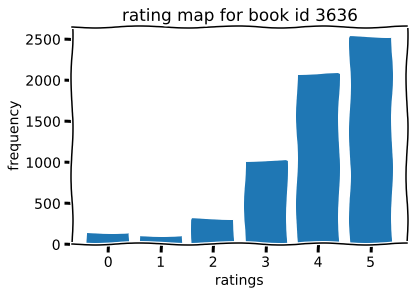

<ipython-input-51-8025f6921809>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_grp['review_text']=book_grp['review_text'].apply(reviewsTextCleaning)


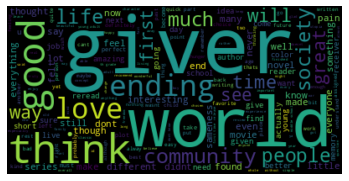

<ipython-input-56-fd1b3065f8e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_grp['polarity_Score']=book_grp['review_text'].apply(getPolarity)
<ipython-input-56-fd1b3065f8e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_grp['sentiment']=book_grp['polarity_Score'].apply(polarityInference)


In [57]:
book_grp,rating_avg=book_gro_analysis('3636')

In [58]:
book_grp['polarity_Score'].corr(book_grp['rating'])

0.21927620378307816

In [59]:
def ratingCategorisation(score):
    if score >3:
        return 'Positive'
    elif score ==3:
        return 'Neutral'
    else:
        return 'Negative'

In [60]:
book_grp['ratingGroup']=book_grp['rating'].apply(ratingCategorisation)

<ipython-input-60-7a25d05dcdf0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_grp['ratingGroup']=book_grp['rating'].apply(ratingCategorisation)


In [61]:
# converting ratingGroup and sentiment column to categories and obtaining correlation
(book_grp['ratingGroup'].astype('category').cat.codes).corr(book_grp['sentiment'].astype('category').cat.codes)

0.17940071283240236

In [62]:
book_grp['sentiment'].value_counts()

Positive    4972
Neutral      619
Negative     565
Name: sentiment, dtype: int64

In [63]:
book_grp['ratingGroup'].value_counts()

Positive    4593
Neutral     1009
Negative     554
Name: ratingGroup, dtype: int64

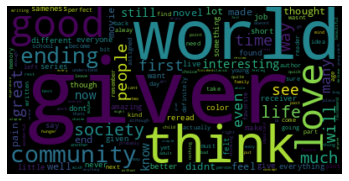

In [64]:
# word cloud generation for positive & negative reviews
wordcloudgeneration(book_grp[book_grp['sentiment']=='Positive'])

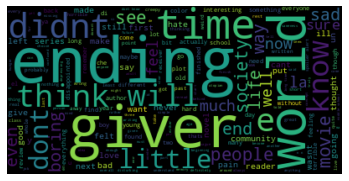

In [65]:
wordcloudgeneration(book_grp[book_grp['sentiment']=='Negative'])